In [1]:
# Import Modules
import cv2
import numpy as np
import matplotlib.pyplot as plt
from math import cos , sin , pi
from scipy.fftpack import dct , idct
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
import heapq
import sys

# Image Processing Module

In [2]:
class ImageProcessingModule:
    """
    Image Processing Module
    
    Objective:
        1. Perform different Image processing Techniques
            1.1) Spatial Average of an Image
            1.2) Reduce Resolution of an Image given Grid Size
            1.3) Reduce Intensity of an Image
            1.4) Rotation of an Image
            1.5) JPEG Compression (Single Channel Image)
            1.6) JPEG Compression (Multi Channel Image)
    """
    def __init__(self,imagePath,quantizationFactor=1,gridSize=1):
        """
        Initialize paramters of the class
        params:
            1. imagePath - (Path of an Image)
            2. QuantizationFactor - (Number of Levels by which you want to reduce the intensity levels)
            3. gridSize - (Denotes the size of the grid)
        """
        self.imagePath = imagePath
        self.originalimage = cv2.imread(self.imagePath)
        self.originalGreyImage = cv2.imread(self.imagePath, cv2.IMREAD_GRAYSCALE)
        self.image = self.originalGreyImage
        self.quantizationFactor = quantizationFactor
        self.originalHeight, self.originalWidth = self.image.shape
        print(f"Height of the image : {self.originalHeight} , Width of the image : {self.originalWidth}")
        self.gridSize = gridSize
        
    def spatialAverage(self, image , neighborhood_size):
        """
        Performs spatial Average of an image using neighborhood averaging technique.
        Keeping the original dimension same 
        """

        height , width , channels = image.shape
        
        #If input image is not a grey scale image , convert it into grey scale image
        if channels == 3:
            image = cv2.cvtColor(image , cv2.COLOR_BGR2GRAY)
            
        averaged_image = np.zeros((height,width),dtype=np.uint8)
        
        #Calculating pad size to make sure that the output image dimensions are same as of input Image.
        pad = neighborhood_size // 2
        paddedImage = cv2.copyMakeBorder(image , pad , pad , pad , pad , cv2.BORDER_CONSTANT, value = 0)
        
        kernel = np.ones((neighborhood_size , neighborhood_size),dtype=np.float32) / (neighborhood_size * neighborhood_size)

        for indexi in range(pad , height + pad):
            for indexj in range(pad , width + pad):
                # Taking a window of neighborhood size from the input image
                window = paddedImage[indexi - pad : indexi + pad , indexj - pad:indexj + pad ]
                #calculating the average of the window and copy the value in averaged image 
                # To Do , can generalize for any statistical operation (sum , median)
                averaged_image[indexi - pad , indexj - pad] = np.sum(window * kernel)
        return averaged_image

   
    def reduceResolution(self,image,gridSize,type="mean"):
        """
        Input : gridSize
        
        Objective:
            1. Reduce the image resolution by the given gridSize.
            2. Replace the grid with the mean/median of the grid values.
        """
        height , width , channels = image.shape
        
        if channels == 3:
            image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
            
        image = np.array(image)

        new_width , new_height = width // gridSize , height // gridSize
        reduced_image = np.zeros((new_height, new_width),dtype=np.uint8)

        for y in range(new_height):
            for x in range(new_width):
                block = image[y * gridSize : (y+1) * gridSize, x * gridSize : (x + 1)*gridSize]
                
                if type == "mean":
                    averageValue = int(np.mean(block))
                else:
                    averageValue = int(np.median(block))
                reduced_image[y,x] = averageValue
        return reduced_image
    
    def reduce_intensity_levels(self,num_levels):

        # Write  a computer program capable of reducing the number of intensity levels 
        # in an image from 256 to 2, in integer powers of 2. The desired number of 
        # intensity levels needs to be a variable input to your program.
        imageArr = np.array(self.image)

        divisor = 256 // num_levels
        reduced_levels = (imageArr // divisor) * divisor
        return reduced_levels
    
    def rotate_point(self,x, y , angle_radian):
        x_rotated = x * cos(angle_radian) - y * sin(angle_radian)
        y_rotated = x * sin(angle_radian) + y * cos(angle_radian)

        return x_rotated , y_rotated
    
    def rotateImage(self,angle,image):
        print(image.shape)
        height , width , _  = image.shape
        image = np.array(image)

        rotated_image = [[0 for _ in range(width)] for _ in range(height)]

        angle_radian = angle * (pi/180)

        for y in range(height):
            for x in range(width):
                new_x , new_y = self.rotate_point(x - width // 2, y- height // 2, angle_radian)
                new_x , new_y = int(new_x) + width // 2, int(new_y) + height // 2

            if 0 <= new_x < width and 0 <= new_y < height:
               rotated_image[y][x] =image[new_y][new_x]
    
        return rotated_image
    
    def divideImageIntoGrids(self,image):
        """
        Input : image
        Objective:
            1. For JPEG Compression  , divide the image into several grids 
            and send for computing discrete cosine transform of the blocks.
        Process:
            1. if the height and width of the image is not divisble by the grid size , resize the image to make it divisible.
        """
        height , width = image.shape
        blocks = []
    
        if height % self.gridSize !=0 or width % self.gridSize !=0:
            print("Operation Not possible, grid size does not divide properly")
            print("Resizing the image to be divisible by the grid size")

            height = (height // self.gridSize) * self.gridSize
            width = (width // self.gridSize) * self.gridSize
            print(f"Resize Image Width : {width}")
            print(f"Resized Image Height: {height}")
        
        image = cv2.resize(image,(width,height))
        image = np.asarray(image)
        
        new_height = height // self.gridSize
        new_width = width // self.gridSize
        for y in range(new_height):
            for x in range(new_width):
                block = image[y*self.gridSize:(y+1)*self.gridSize,x*self.gridSize:(x+1)*self.gridSize]
                blocks.append(block)
        return blocks
    
    def computeDCT(self,blocks):
        """
        Input: blocks from divide Image into grids
        
        Objective:
            1. compute Discrete Cosine Transform for each of the blocks
        """
        for index in range(len(blocks)):
            try:
                blocks[index] = dct(dct(blocks[index].T,norm='ortho').T,norm='ortho')
            except Exception as e:
                print(f"An Error Occured: {e}")
        return blocks

    def invertDCTBlocks(self,blocks):
        """
        Input: blocks for decompressing/decoding the image
        
        Objective:
            1. Inverse discrete cosine transform for the blocks
        """
        for index in range(len(blocks)):
            try:
                blocks[index] = idct(idct(blocks[index].T,norm='ortho').T,norm='ortho')
            except Exception as e:
                print(f"An error Occured {e}")
        return blocks

    def quantizeDCTBlocks(self,blocks):
        """
        Input: blocks after doing the discrete cosine transform of the blocks
        
        Objective:
            1. To compress further , quantize the coefficients of the discrete cosine transforms.
        """
        for index in range(len(blocks)):
            blocks[index] = np.round(blocks[index] / self.quantizationFactor)
        return blocks
    
    def deQuantizeDCTBlocks(self,blocks):
        """
        Input: blocks for Decompress/Decoding the image(Reconstructing the Image)
        
        Objective:
            1. Multiplying the quantized coefficients with the quantized factor to get the original coefficients
        """
        for index in range(len(blocks)):
            blocks[index] = blocks[index] * self.quantizationFactor
        return blocks
    
    def recontructImage(self,blocks):
        """
        Input: blocks after doing the invert Discrete Cosine Transform
        
        Objective:
            1. reconstruct the image from the blocks (opposite of dividing the image into grids)
            2. Given the grids , reconstruct the image.
        """
        reconstructedImage = np.zeros((self.originalHeight, self.originalWidth),dtype=np.uint8)
        for index in range(len(blocks)):
            row , col = (index // (self.originalWidth // self.gridSize)) * self.gridSize , (index % (self.originalWidth // self.gridSize)) * self.gridSize
            reconstructedImage[row : row + self.gridSize , col : col + self.gridSize] = blocks[index]
        return reconstructedImage

    def decompressImage(self,blocks):
        """
        Input: blocks after JPEG Compression
        """
        blocks = self.deQuantizeDCTBlocks(blocks)
        blocks = self.invertDCTBlocks(blocks)
        reconstructedImage = self.recontructImage(blocks)
        return reconstructedImage
    
    def showImage(self,image):
        plt.imshow(image)
        plt.show()
    
    def jpegCompression(self,image):
        """
        Input: Image to be compressed(JPEF Compression)
        
        Objective:
            1. Steps in JPEG Compression
                1.1) Divide the image into different grids and store it.
                1.2) Compute DCT(Discrete Cosine Transform) of the grids.
                1.3) Apply Quantization to the coeficients of the DCT Transform.
        """
        blocks = self.divideImageIntoGrids(image)
        blocks = self.computeDCT(blocks)
        blocks = self.quantizeDCTBlocks(blocks)
        return blocks
    
    def computeHistogram(self,image):
        """
        Represents the frequency distribution of pixel intensities
        """
        histogram = np.zeros(256,dtype=int)
        for row in image:
            for pixel in row:
                histogram[pixel] +=1
        return histogram
    
    def predictionSchemeError(self,predictedImage):
        """
        Input: predicted Image
        
        Objective:
            1. Computes the error between original image and predicted Image
        """
        return np.abs(self.image - predictedImage)
    
    def predictionScheme(self, scheme = 'type1'):
        if scheme == 'type1':
            predictedImage = np.roll(self.image, shift = 1, axis = 0)
        elif scheme == 'type2':
            predictedImage = np.roll(self.image , shift = 1, axis = 1)
        else:
            predictedImage = (np.roll(self.image, shift = 1, axis = 0) +
                              np.roll(self.image, shift = 1, axis = 1) +
                              np.roll(np.roll(self.image, shift = 1, axis = 0),shift = 1, axis = 1)) // 3
        return predictedImage
    
    def convertImageToYCrCb(self,image):
        """
        Input:Image
        
        Objective:
            1. Color Converting the image from BGR to YCrCb (For JPEG Compression)(Color)
        """
        ycrcbImage = cv2.cvtColor(image, cv2.COLOR_BGR2YCrCb)
        return ycrcbImage
    
    def splitImage(self,image):
        """
        Input: Image
        
        Objective:
            1.split Image into channels
        """
        firstChannel , secondChannel , thirdChannel = cv2.split(image) 
        return firstChannel , secondChannel , thirdChannel
    
    def jpegCompressionColorImage(self,image):
        """
        Input: Image
        
        Objective:
            1.Convert the Image Format from BGR To YCrCb
            2.Split the Image into Y , Cr , Cb channels.
            3. Apply JPEG Compression on each channel.
        """
        ycrcbImage = self.convertImageToYCrCb(image)
        y, cr, cb = self.splitImage(ycrcbImage)
        yBlocks = self.jpegCompression(y)
        crBlocks = self.jpegCompression(cr)
        cbBlocks = self.jpegCompression(cb)
        
        return yBlocks , crBlocks , cbBlocks
    
    def jpegDecompressionColorImage(self,yBlocks , crBlocks , cbBlocks):
        """
        Input: Compressed Blocks (of individual Channels) from jpegCompressionColorImage
        
        Objective:
            1. Reconstruct the color image from the compressed blocks
            
        """
        reconstructedyBlock = module.decompressImage(yBlocks)
        reconstructedcrBlock = module.decompressImage(crBlocks)
        reconstructedcbBlock = module.decompressImage(cbBlocks)
        reconstructedYCrCbImage = cv2.merge([reconstructedy, reconstructedcr, reconstructedcb])
        reconstructedBGRImage = cv2.cvtColor(reconstructedYCrCbImage, cv2.COLOR_YCrCb2BGR)
        
        return reconstructedBGRImage
        
            
    
    def plotImages(self,images, titles=None, rows=1, figsize=(10, 10),type='image'):
        """
        Plots a grid of images.

        Args:
        - images: List of image arrays (each image should be a numpy array).
        - titles: List of titles for each image (optional).
        - rows: Number of rows in the grid (optional).
        - figsize: Size of the figure (optional).
        """
        num_images = len(images)
        if titles is None:
            titles = [''] * num_images

        fig, axes = plt.subplots(rows, num_images // rows, figsize=figsize)

        if num_images == 1:
            if type == 'image':
                axes.imshow(images[0])
            else:
                axes.plot(images[0])
            axes.set_title(titles[0])
            axes.axis('off')
        else:
            for i, ax in enumerate(axes.flat):
                if i < num_images:
                    if type == 'image':
                        ax.imshow(images[i])
                    else:
                        ax.plot(images[i])
                    ax.set_title(titles[i])
                    ax.axis('off')

        plt.tight_layout()
        plt.show()



In [3]:
 class node:
        def __init__(self,symbol,freq):
            self.symbol = symbol
            self.freq = freq
            self.left = None
            self.right = None
        def __lt__(self,other):
            return self.freq < other.freq
        
class HuffmanCoding:
    
    def __init__(self,gridSize):
        self.gridSize = gridSize
    
    def calculateFrequency(self,data):
        frequency = Counter(data)
        return frequency
    
    def buildHuffmanTree(self,freq):
        heap = [node(symbol,freq) for symbol,freq in freq.items()]
        heapq.heapify(heap)
    
        while len(heap) > 1:
            left = heapq.heappop(heap)
            right = heapq.heappop(heap)
            
            merged = node(None, left.freq + right.freq)
            merged.left = left
            merged.right = right
            
            heapq.heappush(heap,merged)
        return heap[0]
    
    def huffmanEncode(self,codes,data):
        encodedData = "".join(codes[symbol] for symbol in data)
        return encodedData
    
    def generateCodes(self,root,code="",codes={}):
        if root is None:
            return
        
        if root.symbol is not None:
            codes[root.symbol] = code
        
        self.generateCodes(root.left,code + "0",codes)
        self.generateCodes(root.right,code + "1",codes)
        
        return codes
    
    def reconstructBlocksFromDecodedData(self,decodedData):
        blocks = []
        size = self.gridSize * self.gridSize
        iteration = int(len(decodedData) / size)
        for index in range(iteration):
            block = decodedData[index * size : (index + 1) * size]
            block = np.array(block)
            block = block.reshape(self.gridSize,self.gridSize)
            blocks.append(block)
        return blocks
            
    def huffmanDecode(self,encodedData,root):
        decodedData = []
        node = root
        
        for bit in encodedData:
            if bit == "0":
                node = node.left
            else:
                node = node.right
            
            if node.symbol is not None:
                #decodedData += node.symbol
                decodedData.append(node.symbol)
                node = root
        self.reconstructBlocksFromDecodedData(decodedData)
        return decodedData
    
    def flattenCompressedBlocks(self,blocks):
        concatenateArray = np.concatenate(blocks)
        return concatenateArray.flatten()

# 1. Visualizing Image

## Original Image

In [4]:
imagePath = "../input/images/cheetah.jpg"
module = ImageProcessingModule(imagePath,4,32)
huffmanCoding = HuffmanCoding(32)

Height of the image : 321 , Width of the image : 481


# 2. Spatial Averaging of Image with diferent Neighborhood size (2,4,6,8,10)

In [5]:
averagedImage2  = module.spatialAverage(module.originalimage , 2)
averagedImage4  = module.spatialAverage(module.originalimage , 4)
averagedImage6  = module.spatialAverage(module.originalimage , 6)
averagedImage8  = module.spatialAverage(module.originalimage , 8)
averagedImage10 = module.spatialAverage(module.originalimage , 10)

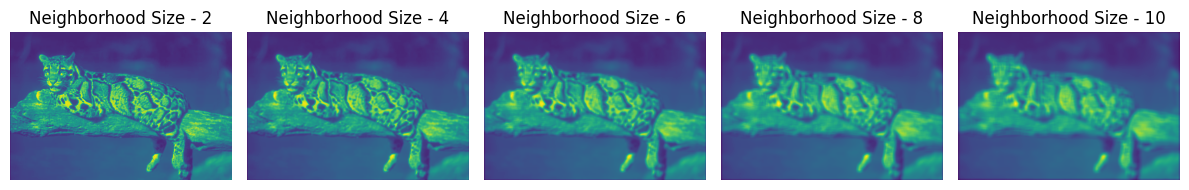

In [6]:
images_list = [averagedImage2,averagedImage4,averagedImage6,averagedImage8,averagedImage10]
titles_list = ['Neighborhood Size - 2', 'Neighborhood Size - 4','Neighborhood Size - 6','Neighborhood Size - 8','Neighborhood Size - 10']

module.plotImages(images_list, titles_list, rows=1, figsize=(12, 6),type='image')

# 3. Reduce Resolution with different Grid Size (2,4,6,8,10)

In [7]:
reduceResolution2  = module.reduceResolution(module.originalimage , 2)
reduceResolution4  = module.reduceResolution(module.originalimage , 4)
reduceResolution6  = module.reduceResolution(module.originalimage , 6)
reduceResolution8  = module.reduceResolution(module.originalimage , 8)
reduceResolution10 = module.reduceResolution(module.originalimage , 10)

## Type = Mean

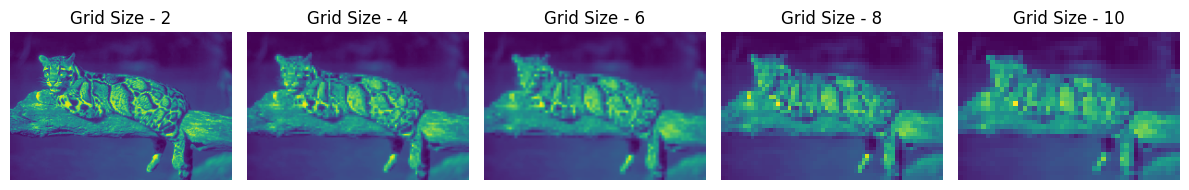

In [8]:
images_list = [reduceResolution2,reduceResolution4,reduceResolution6,reduceResolution8,reduceResolution10]
titles_list = ['Grid Size - 2', 'Grid Size - 4','Grid Size - 6','Grid Size - 8','Grid Size - 10']

module.plotImages(images_list, titles_list, rows=1, figsize=(12, 6),type='image')

## Type = Median 

In [9]:
reduceResolution2  = module.reduceResolution(module.originalimage , 2, "median")
reduceResolution4  = module.reduceResolution(module.originalimage , 4, "median")
reduceResolution6  = module.reduceResolution(module.originalimage , 6, "median")
reduceResolution8  = module.reduceResolution(module.originalimage , 8, "median")
reduceResolution10 = module.reduceResolution(module.originalimage , 10, "median")

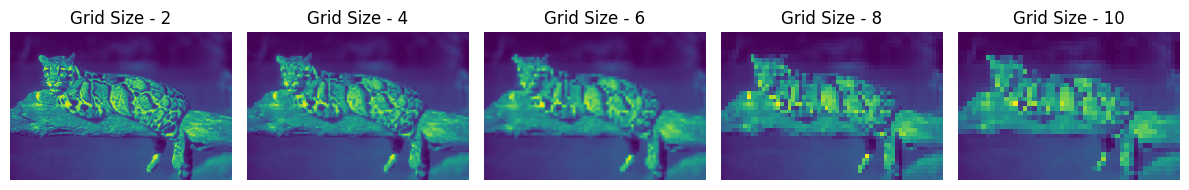

In [10]:
images_list = [reduceResolution2,reduceResolution4,reduceResolution6,reduceResolution8,reduceResolution10]
titles_list = ['Grid Size - 2', 'Grid Size - 4','Grid Size - 6','Grid Size - 8','Grid Size - 10']

module.plotImages(images_list, titles_list, rows=1, figsize=(12, 6),type='image')

# 3. Quantization of Image

## Number of Levels = 2,4,8

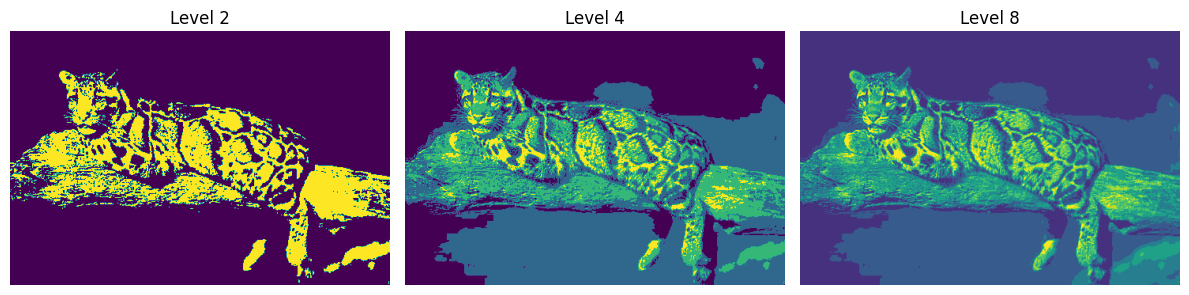

In [11]:
quantizedImage_2 = module.reduce_intensity_levels(2)
quantizedImage_4 = module.reduce_intensity_levels(4)
quantizedImage_8 = module.reduce_intensity_levels(8)

images_list = [quantizedImage_2,quantizedImage_4,quantizedImage_8]
titles_list = ['Level 2', 'Level 4', 'Level 8']

module.plotImages(images_list, titles_list, rows=1, figsize=(12, 6),type='image')

## 3. JPEG Compression (Grey Scale Image)

## Compressed Image

Memory occupied by the Image : 0.1473703384399414 MB
Operation Not possible, grid size does not divide properly
Resizing the image to be divisible by the grid size
Resize Image Width : 480
Resized Image Height: 320
Memory occupied by the Encoded Data : 0.35477256774902344 MB
Memory occupied by Huffman Tree : 4.57763671875e-05 MB


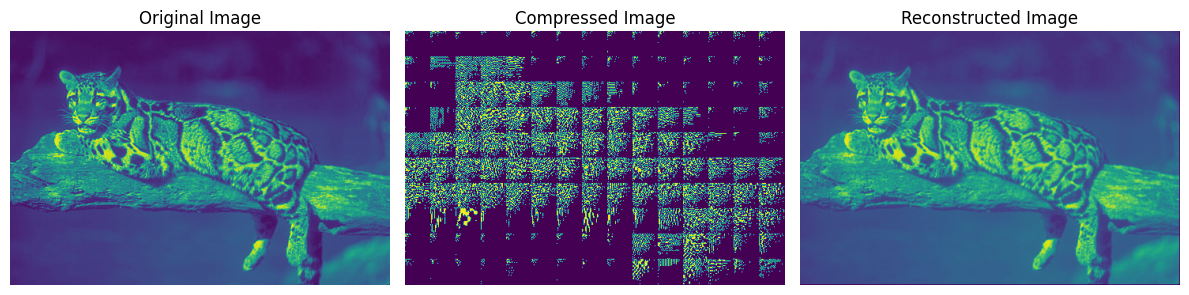

In [12]:
imageSizeBytes = sys.getsizeof(module.originalGreyImage)
imageSizeMBs = imageSizeBytes / (1024 * 1024)
print(f"Memory occupied by the Image : {imageSizeMBs} MB")
blocks= module.jpegCompression(module.originalGreyImage)
flattenCoefficients = huffmanCoding.flattenCompressedBlocks(blocks)
freq = huffmanCoding.calculateFrequency(flattenCoefficients)
huffmanTree = huffmanCoding.buildHuffmanTree(freq)
huffmanCodes = huffmanCoding.generateCodes(huffmanTree)

encodedData = huffmanCoding.huffmanEncode(huffmanCodes,flattenCoefficients)
encodedDataBytes = sys.getsizeof(encodedData)
encodedDataMBs = encodedDataBytes / (1024 * 1024)

huffmanTreeBytes = sys.getsizeof(huffmanTree)
huffmanTreeMBs = huffmanTreeBytes / (1024 * 1024)

print(f"Memory occupied by the Encoded Data : {encodedDataMBs} MB")
print(f"Memory occupied by Huffman Tree : {huffmanTreeMBs} MB")

decodedData = huffmanCoding.huffmanDecode(encodedData, huffmanTree)
reconstructedBlocks = huffmanCoding.reconstructBlocksFromDecodedData(decodedData)

compressedImage = module.recontructImage(reconstructedBlocks)
reconstructedImage = module.decompressImage(reconstructedBlocks)

images_list = [module.originalGreyImage,compressedImage,reconstructedImage]
titles_list = ['Original Image', 'Compressed Image', 'Reconstructed Image']

module.plotImages(images_list, titles_list, rows=1, figsize=(12, 6),type='image')

# 4.Histogram of Image

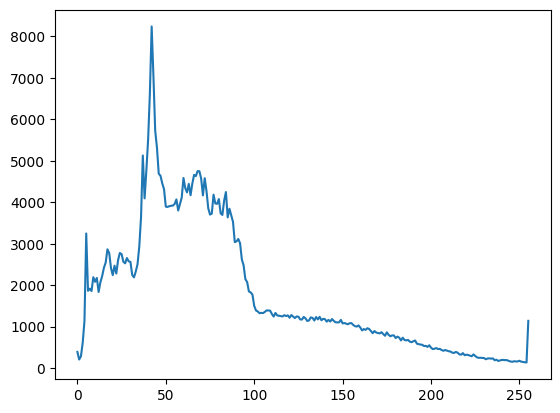

In [13]:
histogram = module.computeHistogram(module.originalimage)
plt.plot(histogram)

## Using Different Prediction Scheme
    
1. predicting based on just the pixel at (-1,0)
2. predicting based on just the pixel at (0,1)
3. predicting based on the average of the pixels at (-1,0), (-1,1), and (0,1)


In [14]:
predictedImage1 = module.predictionScheme('type1')
error1 = module.predictionSchemeError(predictedImage1)
    
predictedImage2 = module.predictionScheme('type2')
error2 = module.predictionSchemeError(predictedImage2)
    
predictedImage3 = module.predictionScheme('type3')
error3 = module.predictionSchemeError(predictedImage3)

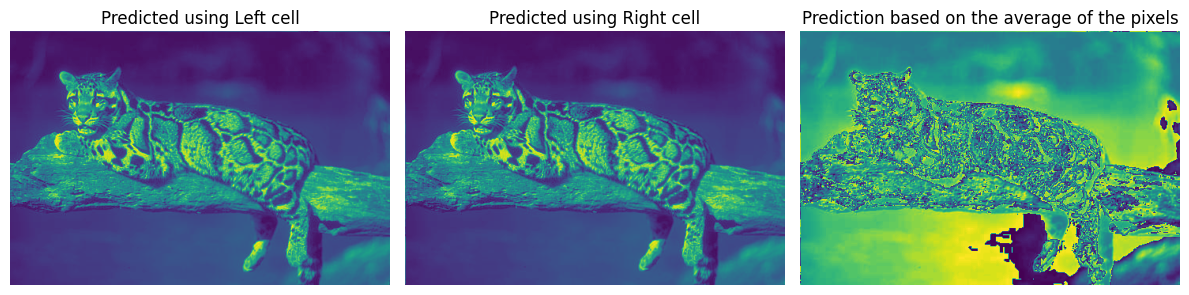

In [15]:
images_list = [predictedImage1, predictedImage2, predictedImage3]
titles_list = ['Predicted using Left cell', 'Predicted using Right cell', 'Prediction based on the average of the pixels']
module.plotImages(images_list, titles_list, rows=1, figsize=(12, 6),type='image')

## Calculating Error (Original Image - Predicted Image)

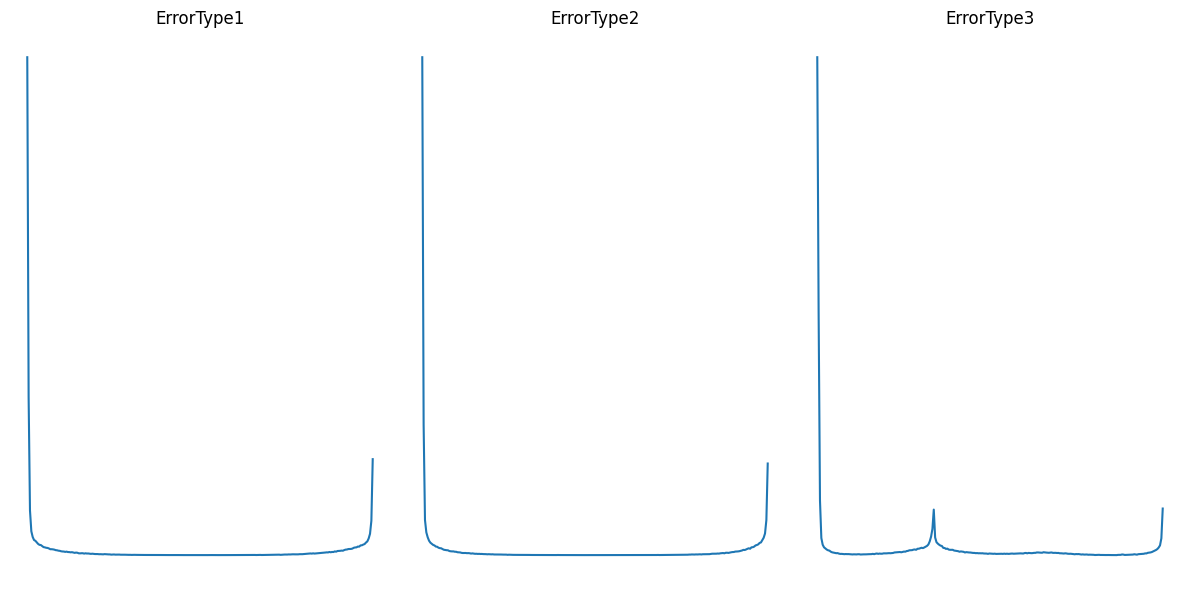

In [16]:
histogramError1 = module.computeHistogram(error1)
histogramError2 = module.computeHistogram(error2)
histogramError3 = module.computeHistogram(error3)

histogram_list = [histogramError1, histogramError2, histogramError3]
titles_list = ["ErrorType1", "ErrorType2", "ErrorType3"]

module.plotImages(histogram_list, titles_list, rows=1, figsize=(12, 6),type='plot')

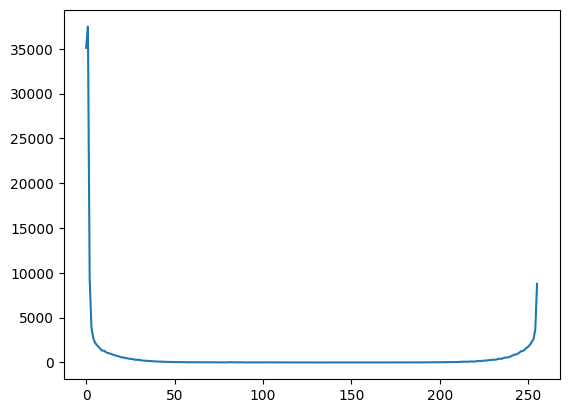

In [17]:
error =  module.originalGreyImage - reconstructedImage
histogramError = module.computeHistogram(error)
plt.plot(histogramError)

# 5.JPEG Compression (Color Images)

## Original Image (YCrCb)

In [18]:
ycrcbImage = module.convertImageToYCrCb(module.originalimage)

In [19]:
y , cr , cb = module.splitImage(ycrcbImage)

In [20]:
yBlocks , crBlocks , cbBlocks = module.jpegCompressionColorImage(module.originalimage)
yBlocksCompressed  = module.recontructImage(yBlocks)
crBlocksCompressed = module.recontructImage(crBlocks)
cbBlocksCompressed = module.recontructImage(cbBlocks)

Operation Not possible, grid size does not divide properly
Resizing the image to be divisible by the grid size
Resize Image Width : 480
Resized Image Height: 320
Operation Not possible, grid size does not divide properly
Resizing the image to be divisible by the grid size
Resize Image Width : 480
Resized Image Height: 320
Operation Not possible, grid size does not divide properly
Resizing the image to be divisible by the grid size
Resize Image Width : 480
Resized Image Height: 320


In [21]:
reconstructedy = module.decompressImage(yBlocks)
reconstructedcr = module.decompressImage(crBlocks)
reconstructedcb = module.decompressImage(cbBlocks)

In [22]:
reconstructedYcrCbImage = cv2.merge([reconstructedy, reconstructedcr, reconstructedcb])

In [23]:
reconstructedBGRImage = cv2.cvtColor(reconstructedYcrCbImage, cv2.COLOR_YCrCb2BGR)

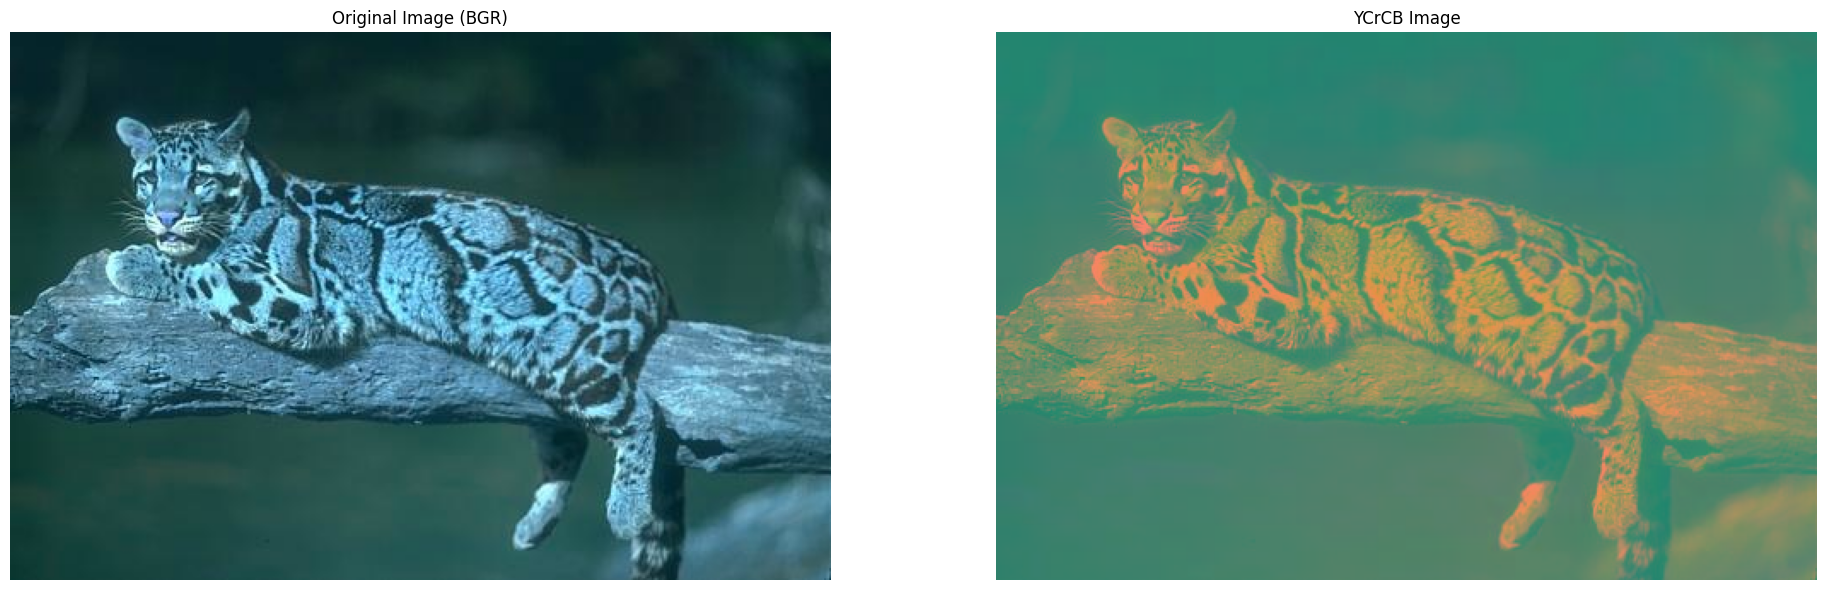

In [24]:
images_list = [module.originalimage,
               ycrcbImage]
titles_list = ['Original Image (BGR)',
               'YCrCB Image']
module.plotImages(images_list, titles_list, rows=1, figsize=(20, 6),type='image')

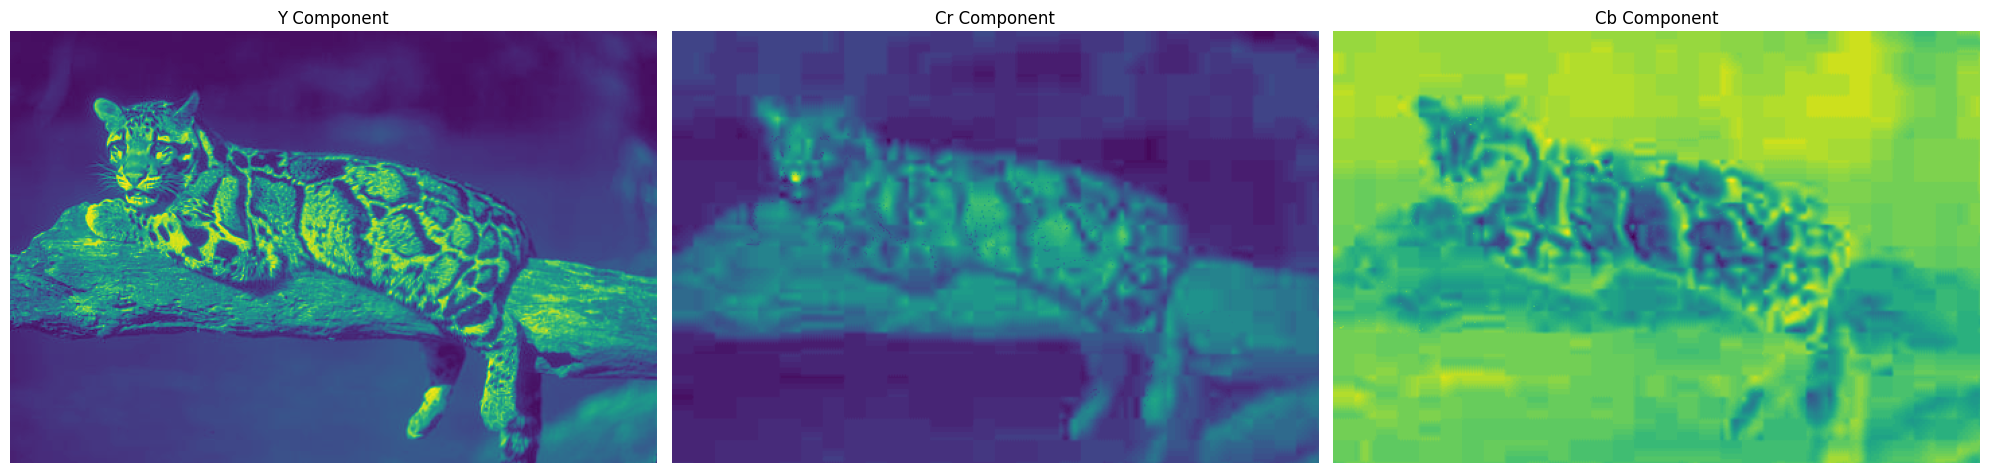

In [25]:
images_list = [y,cr,cb]
titles_list = ['Y Component', 'Cr Component' , 'Cb Component']
module.plotImages(images_list, titles_list, rows=1, figsize=(20, 6),type='image')

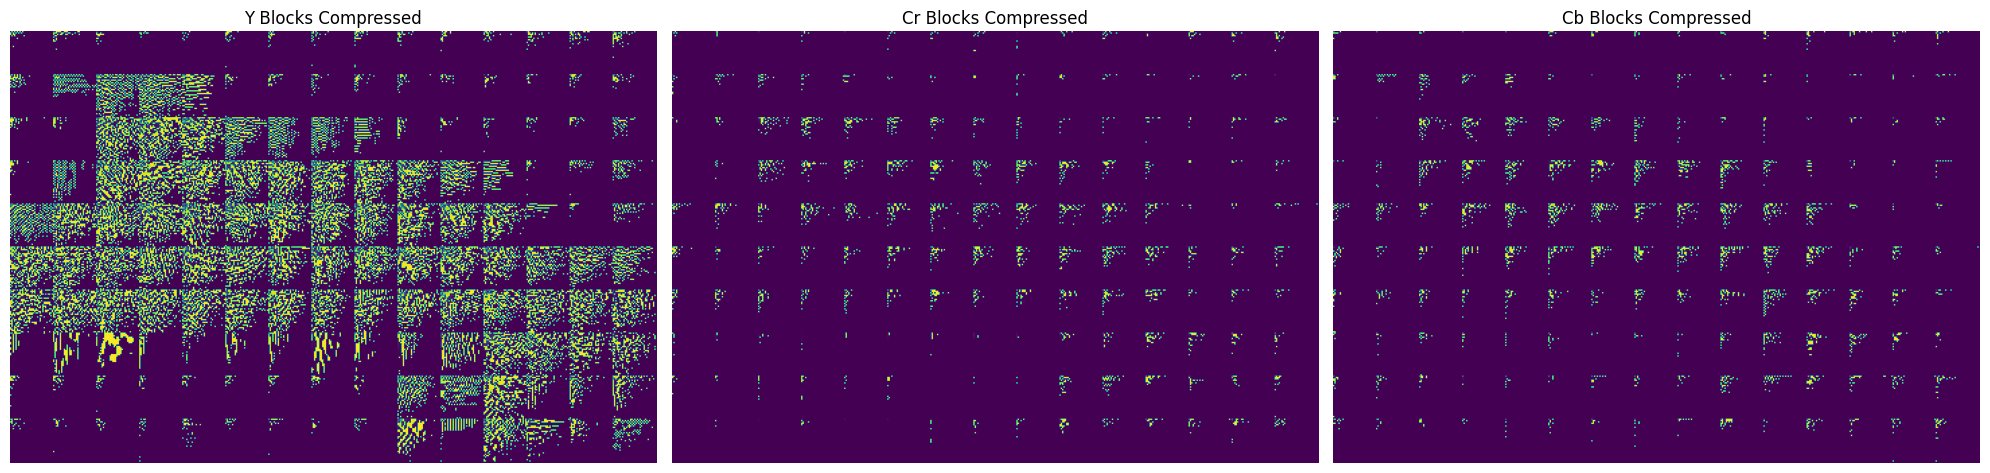

In [26]:
images_list = [yBlocksCompressed,
               crBlocksCompressed,
               cbBlocksCompressed,]

titles_list = ['Y Blocks Compressed', 'Cr Blocks Compressed' , 'Cb Blocks Compressed']
module.plotImages(images_list, titles_list, rows=1, figsize=(20, 6),type='image')

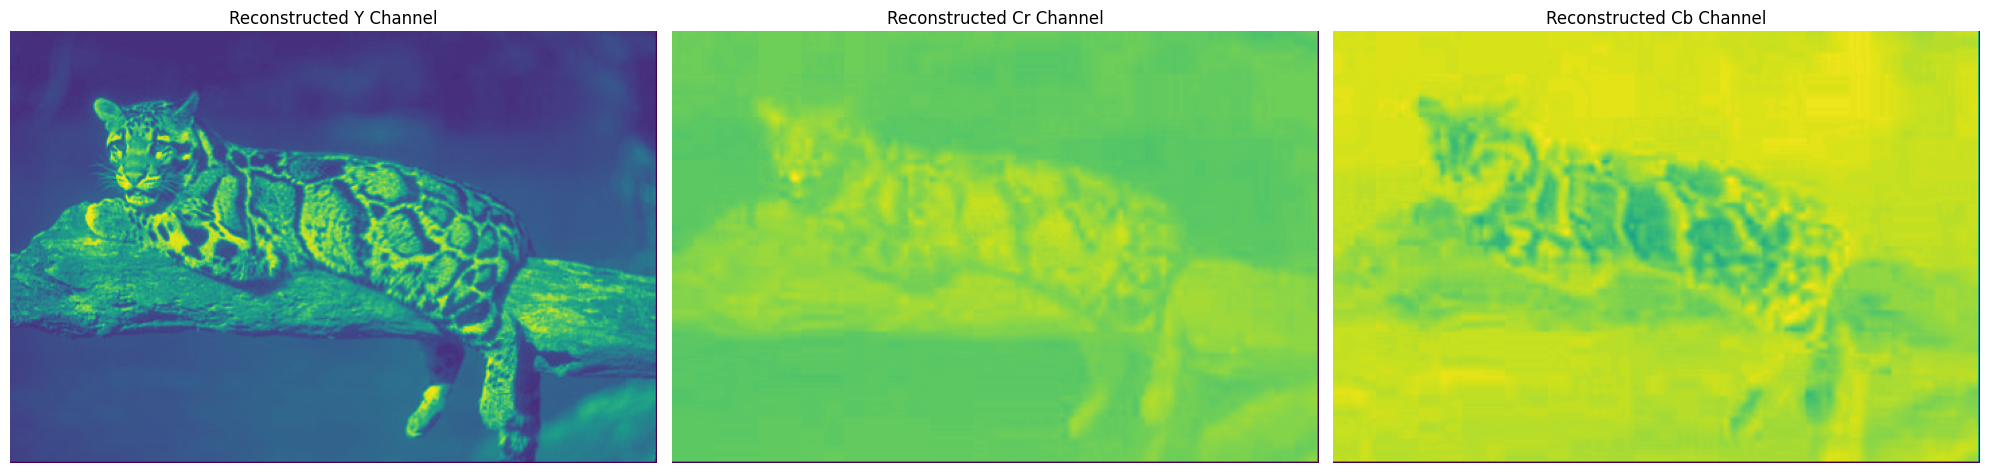

In [27]:
images_list = [reconstructedy,
               reconstructedcr,
               reconstructedcb,]

titles_list = ['Reconstructed Y Channel', 'Reconstructed Cr Channel' , 'Reconstructed Cb Channel']
module.plotImages(images_list, titles_list, rows=1, figsize=(20, 6),type='image')

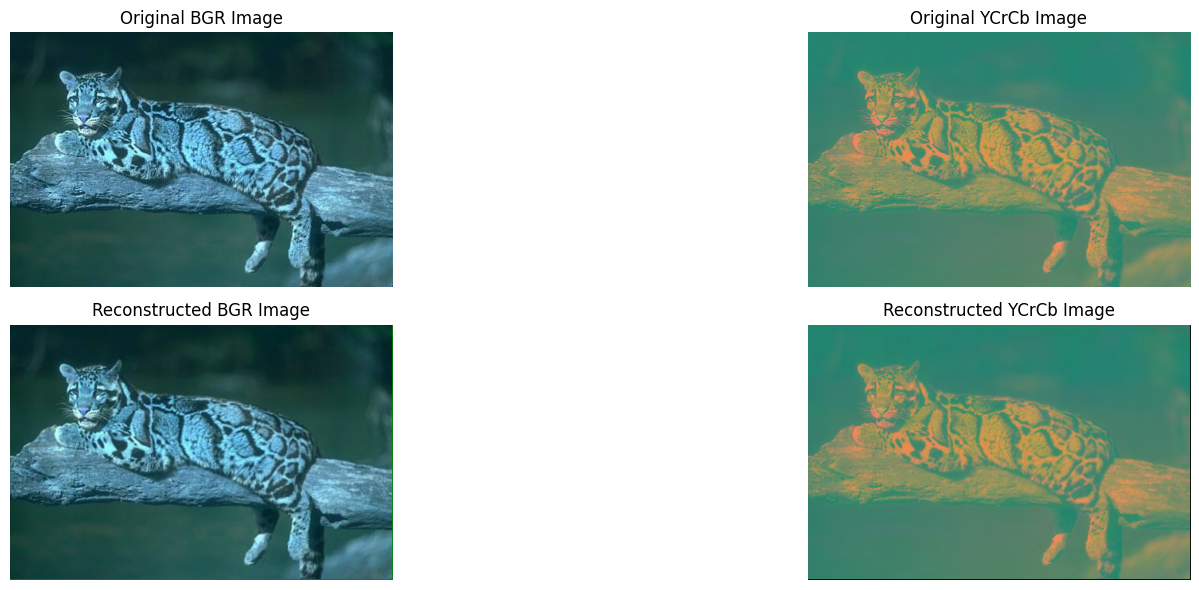

In [28]:
images_list = [ module.originalimage,
               ycrcbImage,
               reconstructedBGRImage,
               reconstructedYcrCbImage,]

titles_list = ['Original BGR Image' , 'Original YCrCb Image','Reconstructed BGR Image', 'Reconstructed YCrCb Image']
module.plotImages(images_list, titles_list, rows=2, figsize=(20, 6),type='image')

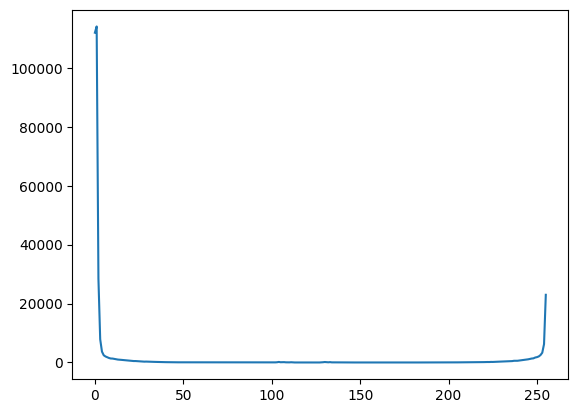

In [29]:
error =  ycrcbImage - reconstructedYcrCbImage
histogramError = module.computeHistogram(error)
plt.plot(histogramError)

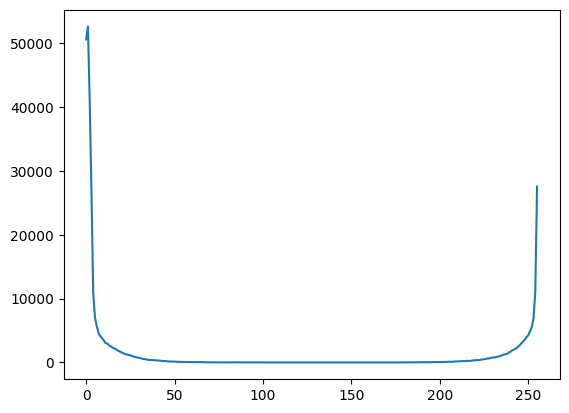

In [30]:
error =  module.originalimage - reconstructedBGRImage
histogramError = module.computeHistogram(error)
plt.plot(histogramError)